# Topic Modeling Exploration
Topic modeling is a type of unsupervised learning for natural language processing problems that groups observations together by topic. 

## Imports

In [ ]:
#!pip install spacy

In [ ]:
#!pip install pyLDAvis

In [1]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

#nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('./Data/Lemmatized_df.csv')

In [3]:
df.head()

,rest_cost,cuisine_type,rest_name,rest_rating,rest_review,address_only,rest_borough,rest_zip_code,lemmatized
0,2.0,Pizza,Mama’s Too,8.3,A typical NYC slice shop has a few basic eleme...,"2750 Broadway, New York, NY 10025",Manhattan,10025,typical nyc slice shop basic element counter g...
1,4.0,Japanese,Omakase Room By Tatsu,7.7,Tolerance for group trips can vary widely. Som...,"14 Christopher St, New York, NY 10014",Manhattan,10014,tolerance group trip vary widely people intern...
2,4.0,Japanese,Sushi Azabu,8.5,When the apocalypse eventually comes for New Y...,"428 Greenwich St., New York, NY 10013",Manhattan,10013,apocalypse eventually come new york city going...
3,3.0,Seafood,Saint Julivert Fisherie,7.7,"When you’re young, you don’t have to think muc...","264 Clinton St, New York, NY 11201",Brooklyn,11201,young think much decision know attempt deep en...
4,2.0,Russian,Farida,8.0,"There’s a bleak, sweaty place on 34th Street w...","498 9th Ave, New York, NY 10018",Manhattan,10018,bleak sweaty place 34th street adult run 6 yar...


# Text Preprocessing
Topic modeling with gensim and spaCy is different than other other NLP preprocessing and unsupervised learning techniques I've worked with in the past. This is because the libraries offer different capabilities. The process for preparing data is:
1. Create a list of the documents to analyze
2. Tokenize each document
3. Clean text - remove stopwords, punctuation and non-alphabetical characters
4. Create a gensim `Dictionary` object: this is a way of keeping track of words with a numeric id.
5. Create a gensim `Corpus` using gensim's `doc2bow`. This is a list of tuples for each document that refers to the numeric id and how many times it appears in that document.<br>

Below, I have created a function that does all the text preprocesseing and returns the variables I am interested in keeping. I have also shown how to do this step by step.


#### 1. Create a list of the documents to analyze

In [4]:
data = list(df['rest_review'].values)

In [5]:
#create a variable for the length of the data
data_len = len(data)

#### 2. Tokenize each document

In [6]:
def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text

In [7]:
STOPWORDS = stopwords.words('english')

#### 3. Clean text - remove stopwords, punctuation and non-alphabetical characters

In [8]:
# For gensim we need to tokenize the data and filter out stopwords
tokenized_cleaned = []
for review in data:
    tokenized_cleaned.append(clean_text(review))

#### 4. Create a gensim `Dictionary` object: this is a way of keeping track of words with a numeric id.

In [9]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(tokenized_cleaned)

#### 5. Create a gensim `Corpus` using gensim's `doc2bow`. This is a list of tuples for each document that refers to the numeric id and how many times it appears in that document.

In [10]:
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in tokenized_cleaned]

In [11]:
#Example of how the corpus looks
print(corpus[20])

[(1, 1), (36, 2), (46, 2), (51, 1), (53, 1), (54, 1), (55, 2), (65, 5), (66, 2), (75, 1), (78, 1), (84, 2), (85, 1), (87, 1), (90, 11), (98, 1), (102, 1), (104, 1), (110, 2), (115, 3), (122, 1), (128, 3), (129, 1), (140, 1), (154, 1), (157, 1), (160, 1), (167, 1), (176, 2), (177, 1), (178, 1), (181, 1), (186, 1), (188, 1), (189, 1), (191, 1), (195, 1), (199, 1), (202, 1), (214, 1), (218, 3), (244, 1), (246, 3), (251, 2), (255, 1), (256, 1), (266, 1), (279, 2), (283, 3), (294, 2), (296, 4), (304, 3), (318, 5), (319, 1), (321, 1), (328, 3), (337, 2), (338, 1), (347, 1), (351, 1), (353, 1), (354, 1), (356, 1), (360, 2), (367, 1), (378, 1), (389, 2), (401, 1), (408, 1), (409, 1), (413, 1), (420, 2), (424, 1), (427, 1), (434, 1), (436, 1), (447, 1), (448, 1), (450, 1), (456, 3), (465, 3), (477, 1), (483, 1), (484, 2), (494, 1), (502, 1), (515, 1), (527, 1), (529, 1), (530, 1), (538, 1), (552, 1), (564, 1), (569, 1), (573, 1), (583, 1), (590, 1), (593, 1), (604, 1), (616, 1), (624, 1), (633,

#### Function to complete text preprocessing

In [68]:
def topic_model_preprocess(text, STOPWORDS):
    #tokenize text
    tokenized_cleaned = []
    for review in text:
        tokenized_text = word_tokenize(review.lower()) #word_tokenize is an nltk function
    
    #clean text
        cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    
    #List of lists
        tokenized_cleaned.append(cleaned_text)
        
    #Create dictionary
    dictionary = corpora.Dictionary(tokenized_cleaned)
    
    #Create corpus
    corpus = [dictionary.doc2bow(word) for word in tokenized_cleaned]
    
    return dictionary, corpus, tokenized_cleaned
    

In [69]:
d_trial, c_trial, cleaned_tokens = topic_model_preprocess(data, STOPWORDS)

### Build the Model
The necessary arguments are:
- `corpus`
- `num_topics`
- `id2word` 

In [16]:
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, 
                            num_topics=10, #10 Topics
                            id2word=dictionary,
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)

In [17]:
# Print the Keywords for each of the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.028*"pizza" + 0.015*"slice" + 0.008*"pie" + 0.008*"line" + 0.006*"game" + 0.006*"oven" + 0.006*"pies" + 0.006*"porchetta" + 0.005*"hype" + 0.005*"expected"'), (1, '0.018*"artichoke" + 0.009*"ribbon" + 0.008*"caracas" + 0.006*"fast" + 0.005*"fajitas" + 0.005*"establishments" + 0.005*"abc" + 0.005*"arepas" + 0.005*"salsa" + 0.005*"box"'), (2, '0.041*"ramen" + 0.010*"broth" + 0.009*"thai" + 0.008*"noodle" + 0.007*"flex" + 0.007*"ippudo" + 0.007*"noodles" + 0.006*"totto" + 0.006*"soup" + 0.005*"dropped"'), (3, '0.014*"like" + 0.012*"food" + 0.012*"restaurant" + 0.011*"good" + 0.011*"one" + 0.010*"place" + 0.008*"get" + 0.007*"new" + 0.007*"people" + 0.007*"also"'), (4, '0.020*"lobster" + 0.013*"chicken" + 0.010*"roll" + 0.007*"blue" + 0.007*"salad" + 0.007*"crazy" + 0.006*"mussels" + 0.006*"burger" + 0.006*"bone" + 0.006*"fried"'), (5, '0.026*"sushi" + 0.013*"fish" + 0.008*"japanese" + 0.006*"per" + 0.005*"decor" + 0.004*"midtown" + 0.004*"pieces" + 0.004*"gari" + 0.004*"tuna" + 0.

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_cleaned, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.28319857337966

Coherence Score:  0.43562434498342484


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.418509 -0.054476       1        1  71.791542
5      0.005261 -0.156410       2        1   4.674457
0      0.066089  0.287335       3        1   4.622446
4     -0.059207 -0.054656       4        1   3.992993
8     -0.063654 -0.001612       5        1   3.393425
6     -0.065248  0.006093       6        1   3.117555
7     -0.059393 -0.016326       7        1   2.801363
1     -0.088392  0.003820       8        1   2.178845
9     -0.076309 -0.007546       9        1   1.787282
2     -0.077656 -0.006222      10        1   1.640092, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
1281   Default   238.000000     chicken   238.000000  30.0000  30.0000
128    Default   173.000000       pizza   173.000000  29.0000  29.0000
229    Default   219.000000        fish   219.000000  28.0000  28.0000
300    Default   161.000000       sushi   161.000000  27.0000  27.0000
2358   Default   119.000000     mexican   119.000000  26.0000  26.0000
1893   Default   154.000000      burger   154.000000  25.0000  25.0000
1308   Default   169.000000         hit   169.000000  24.0000  24.0000
900    Default    90.000000       ramen    90.000000  23.0000  23.0000
218    Default   382.000000      dinner   382.000000  22.0000  22.0000
3263   Default   115.000000     lobster   115.000000  21.0000  21.0000
3399   Default   107.000000      brunch   107.000000  20.0000  20.0000
638    Default    79.000000       tacos    79.000000  19.0000  19.0000
12     Default   497.000000        best   497.000000  18.0000  18.0000
246    Default   347.000000        meal   347.000000  17.0000  17.0000
279    Default  1117.000000  restaurant  1117.000000  16.0000  16.0000
367    Default  1190.000000        food  1190.000000  15.0000  15.0000
536    Default   126.000000       fried   126.000000  14.0000  14.0000
154    Default    93.000000       slice    93.000000  13.0000  13.0000
741    Default   125.000000        line   125.000000  12.0000  12.0000
447    Default   373.000000       table   373.000000  11.0000  11.0000
54     Default   174.000000        ever   174.000000  10.0000  10.0000
129    Default  1015.000000       place  1015.000000   9.0000   9.0000
1460   Default   103.000000       salad   103.000000   8.0000   8.0000
113    Default   172.000000         nyc   172.000000   7.0000   7.0000
78     Default  1094.000000        good  1094.000000   6.0000   6.0000
90     Default  1412.000000        like  1412.000000   5.0000   5.0000
1097   Default    96.000000       cheap    96.000000   4.0000   4.0000
440    Default   323.000000       still   323.000000   3.0000   3.0000
4065   Default    71.000000     midtown    71.000000   2.0000   2.0000
1112   Default    64.000000       greek    64.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
4729   Topic10     7.665613      pushed     8.403812   4.0185  -5.6637
10086  Topic10     7.182289         rai     7.919382   4.0127  -5.7288
9905   Topic10     6.779871        ivan     7.516961   4.0072  -5.7865
7795   Topic10     6.695309       barns     7.432573   4.0060  -5.7990
12967  Topic10     6.610323      spruce     7.348137   4.0046  -5.8118
14409  Topic10     6.388745       aldea     7.126085   4.0012  -5.8459
10630  Topic10     6.275803   warranted     7.013904   3.9992  -5.8637
11383  Topic10     6.274656    entryway     7.014237   3.9990  -5.8639
8472   Topic10     6.080772      steamy     6.818019   3.9960  -5.8953
7684   Topic10     6.080748      clever     6.818029   3.9960  -5.8953
12299  Topic10     5.951081       perry     6.689354   3.9935  -5.9169
14870  Topic10     5.804172      geisha     6.541567   3.9908  -5.9419
14871  Topic10     5.804172        inc.     6.541567   3.9908  -5.9419
14872  Topic10     5.804172   polishing    

#### It seems like there is a large topic with pretty general words. I will add these to a list of stopwords and remove these in the preprocessing step.

In [20]:
lda_model.get_topic_terms(3)

[(90, 0.014497536),
 (367, 0.012296135),
 (279, 0.011550464),
 (78, 0.011302702),
 (115, 0.01078258),
 (129, 0.010493399),
 (73, 0.00758488),
 (401, 0.007042163),
 (266, 0.006795499),
 (1, 0.0066784373)]

We can extract the top keywords for each topic easily, using `lda_model.top_topics(corpus)` and reference the index for the topic of interest and then the `[0]` index will give a list of tuples with the first value being the percentage and the second being the actual word.

In [21]:
def get_new_stopwords(model, idx):
    new_stops = []
    for i in model.top_topics(corpus)[idx][0]:
        new_stops.append(i[1])
    return new_stops

In [22]:
new_stopwords = get_new_stopwords(lda_model, 0)

### Build a second model after adding more stop words

In [57]:
stpwrds = stopwords.words('english')

In [58]:
stpwrds.extend(new_stopwords)

In [70]:
dictionary_2, corpus_2, cleaned_tokens_2 = topic_model_preprocess(text=data, STOPWORDS=stpwrds)

In [71]:
# Build the LDA model
lda_model_2 = models.LdaModel(corpus=corpus_2, 
                            num_topics=10, #10 Topics
                            id2word=dictionary_2,
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)

In [72]:
# Print the Keywords for each of the 10 topics
print(lda_model_2.print_topics())

doc_lda_2 = lda_model_2[corpus_2]

[(0, '0.015*"upper" + 0.008*"west" + 0.007*"side" + 0.006*"location" + 0.005*"dollar" + 0.004*"totto" + 0.004*"north" + 0.004*"smith" + 0.004*"sleep" + 0.004*"man"'), (1, '0.017*"artichoke" + 0.009*"fat" + 0.006*"thai" + 0.006*"rate" + 0.006*"dudes" + 0.005*"focused" + 0.004*"dropped" + 0.004*"real" + 0.004*"box" + 0.004*"forty"'), (2, '0.015*"ramen" + 0.013*"infatuation" + 0.010*"blue" + 0.007*"review" + 0.006*"paella" + 0.006*"hell" + 0.005*"authentic" + 0.005*"macao" + 0.005*"reasonably" + 0.005*"week"'), (3, '0.022*"sushi" + 0.013*"fish" + 0.006*"hour" + 0.005*"tuna" + 0.005*"japanese" + 0.005*"beers" + 0.005*"downstairs" + 0.005*"establishments" + 0.004*"pieces" + 0.004*"manhattan"'), (4, '0.021*"lobster" + 0.011*"roll" + 0.010*"fish" + 0.009*"madison" + 0.009*"oyster" + 0.008*"man" + 0.008*"clam" + 0.007*"mussels" + 0.007*"local" + 0.007*"bus"'), (5, '0.023*"greek" + 0.017*"wine" + 0.010*"double" + 0.010*"pylos" + 0.009*"spanish" + 0.006*"wines" + 0.006*"kept" + 0.005*"clay" + 0.

In [73]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_2.log_perplexity(corpus_2))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_2 = CoherenceModel(model=lda_model_2, texts=cleaned_tokens_2, dictionary=dictionary_2, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)


Perplexity:  -8.605954992816665

Coherence Score:  0.38135252529468355


In [75]:
vis_2 = pyLDAvis.gensim.prepare(lda_model_2, corpus_2, dictionary_2)
vis_2

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.392408 -0.027772       1        1  60.439526
2     -0.019679  0.112100       2        1   6.407737
3     -0.020006 -0.067285       3        1   6.188737
7     -0.025695  0.256263       4        1   5.925544
6     -0.029729 -0.180449       5        1   5.574983
0      0.090324 -0.024359       6        1   3.584660
4      0.093554 -0.002666       7        1   3.358418
9      0.078027 -0.026721       8        1   3.321003
1      0.120266 -0.010924       9        1   2.998593
5      0.105346 -0.028188      10        1   2.200799, topic_info=      Category        Freq         Term       Total  loglift  logprob
term                                                                 
303    Default  260.000000         wine  260.000000  30.0000  30.0000
118    Default  189.000000        pizza  189.000000  29.0000  29.0000
285    Default  162.000000        sushi  162.000000  28.0000  28.0000
216    Default  192.000000         fish  192.000000  27.0000  27.0000
1673   Default  138.000000      italian  138.000000  26.0000  26.0000
139    Default  224.000000         side  224.000000  25.0000  25.0000
2338   Default  119.000000      mexican  119.000000  24.0000  24.0000
3243   Default   99.000000      lobster   99.000000  23.0000  23.0000
880    Default  121.000000        ramen  121.000000  22.0000  22.0000
268    Default  269.000000         room  269.000000  21.0000  21.0000
4120   Default  170.000000  infatuation  170.000000  20.0000  20.0000
177    Default  149.000000         west  149.000000  19.0000  19.0000
618    Default   90.000000        tacos   90.000000  18.0000  18.0000
1261   Default  256.000000      chicken  256.000000  17.0000  17.0000
143    Default   97.000000        slice   97.000000  16.0000  16.0000
111    Default   96.000000         park   96.000000  15.0000  15.0000
1092   Default   63.000000        greek   63.000000  14.0000  14.0000
3178   Default   89.000000         roll   89.000000  13.0000  13.0000
1175   Default  293.000000         east  293.000000  12.0000  12.0000
487    Default  154.000000         date  154.000000  11.0000  11.0000
170    Default   72.000000        upper   72.000000  10.0000  10.0000
129    Default  133.000000         real  133.000000   9.0000   9.0000
6846   Default   61.000000    artichoke   61.000000   8.0000   8.0000
929    Default   85.000000         blue   85.000000   7.0000   7.0000
233    Default  346.000000         meal  346.000000   6.0000   6.0000
721    Default  133.000000         line  133.000000   5.0000   5.0000
1436   Default  132.000000       review  132.000000   4.0000   4.0000
13     Default  215.000000          bit  215.000000   3.0000   3.0000
399    Default  161.000000      quality  161.000000   2.0000   2.0000
4045   Default   99.000000      midtown   99.000000   1.0000   1.0000
...        ...         ...          ...         ...      ...      ...
2294   Topic10    7.718273         yard    8.497690   3.7201  -5.8283
4024   Topic10    7.574675     spaniard    8.349505   3.7190  -5.8471
2528   Topic10    7.186758      satisfy    7.962875   3.7138  -5.8997
12969  Topic10    7.212689       hyping    7.993795   3.7135  -5.8961
1645   Topic10    7.029486    antipasti    7.804475   3.7118  -5.9218
9540   Topic10    6.731520       organs    7.506657   3.7074  -5.9651
2482   Topic10    6.489884    delivered    7.264946   3.7035  -6.0017
7674   Topic10    6.441993      terroir    7.216568   3.7028  -6.0091
14913  Topic10    6.337344     striking    7.112059   3.7010  -6.0255
14910  Topic10    6.337344       j-date    7.112059   3.7010  -6.0255
14912  Topic10    6.337344        rabid    7.112059   3.7010  -6.0255
2176   Topic10    6.071841        tapas    6.846673   3.6962  -6.0683
638    Topic10    5.594493         vara    6.369071   3.6867  -6.1501
3047   Topic10    5.466370       backup    6.241769   3.6837  -6.1733
658    Topic10    5

In [76]:
#Try with 5 topics but the same data
# Build the LDA model
lda_model_3 = models.LdaModel(corpus=corpus_2, 
                            num_topics=5, #5 Topics
                            id2word=dictionary_2,
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model_3.log_perplexity(corpus_2))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_3 = CoherenceModel(model=lda_model_3, texts=cleaned_tokens_2, dictionary=dictionary_2, coherence='c_v')
coherence_lda_3 = coherence_model_lda_3.get_coherence()
print('\nCoherence Score: ', coherence_lda_3)


Perplexity:  -8.571635675060161

Coherence Score:  0.3576156410974661


In [78]:
vis_3 = pyLDAvis.gensim.prepare(lda_model_3, corpus_2, dictionary_2)
vis_3

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.228902  0.055595       1        1  57.198788
2     -0.090792 -0.134050       2        1  16.570183
3     -0.056627  0.072423       3        1  15.686284
1      0.203945  0.114560       4        1   5.731858
0      0.172377 -0.108529       5        1   4.812887, topic_info=      Category        Freq         Term       Total  loglift  logprob
term                                                                 
118    Default  188.000000        pizza  188.000000  30.0000  30.0000
880    Default  110.000000        ramen  110.000000  29.0000  29.0000
285    Default  169.000000        sushi  169.000000  28.0000  28.0000
2338   Default  104.000000      mexican  104.000000  27.0000  27.0000
618    Default   81.000000        tacos   81.000000  26.0000  26.0000
1017   Default  164.000000         pork  164.000000  25.0000  25.0000
143    Default   87.000000        slice   87.000000  24.0000  24.0000
216    Default  217.000000         fish  217.000000  23.0000  23.0000
4045   Default   94.000000      midtown   94.000000  22.0000  22.0000
1261   Default  229.000000      chicken  229.000000  21.0000  21.0000
2137   Default   80.000000          bbq   80.000000  20.0000  20.0000
6846   Default   50.000000    artichoke   50.000000  19.0000  19.0000
3809   Default   78.000000        style   78.000000  18.0000  18.0000
959    Default  159.000000       dining  159.000000  17.0000  17.0000
592    Default  111.000000     sandwich  111.000000  16.0000  16.0000
116    Default   48.000000          pie   48.000000  15.0000  15.0000
929    Default   93.000000         blue   93.000000  14.0000  14.0000
233    Default  322.000000         meal  322.000000  13.0000  13.0000
1077   Default   86.000000        cheap   86.000000  12.0000  12.0000
170    Default   82.000000        upper   82.000000  11.0000  11.0000
2355   Default   36.000000         taco   36.000000  10.0000  10.0000
8701   Default   60.000000       eleven   60.000000   9.0000   9.0000
189    Default  420.000000         back  420.000000   8.0000   8.0000
521    Default  180.000000          got  180.000000   7.0000   7.0000
111    Default  107.000000         park  107.000000   6.0000   6.0000
3544   Default   57.000000      madison   57.000000   5.0000   5.0000
754    Default   55.000000         rice   55.000000   4.0000   4.0000
289    Default  283.000000        thing  283.000000   3.0000   3.0000
344    Default  143.000000   experience  143.000000   2.0000   2.0000
1873   Default  169.000000       burger  169.000000   1.0000   1.0000
...        ...         ...          ...         ...      ...      ...
4680    Topic5    9.554032      craving   10.390633   2.9499  -6.3974
9885    Topic5    8.290200         ivan    9.026754   2.9488  -6.5393
14768   Topic5    8.374320      benches    9.125031   2.9480  -6.5292
9627    Topic5    8.286868     fountain    9.030442   2.9479  -6.5397
11243   Topic5    8.615757      matches    9.405645   2.9462  -6.5008
7132    Topic5    8.514218        moral    9.297268   2.9459  -6.5127
5168    Topic5    8.221394          uws    8.989237   2.9446  -6.5477
13305   Topic5    8.057283     headsets    8.829647   2.9423  -6.5678
10774   Topic5    7.665986         vote    8.417675   2.9403  -6.6176
8902    Topic5    7.850242       backed    8.621050   2.9402  -6.5938
1571    Topic5    7.740897      cookies    8.515354   2.9385  -6.6079
2395    Topic5   17.515678        homey   19.275105   2.9382  -5.7913
14911   Topic5   25.512011        pylos   29.644857   2.8837  -5.4152
2178    Topic5   18.556473         thai   23.462181   2.7993  -5.7336
3313    Topic5   12.173418      pickles   15.856793   2.7695  -6.1551
2323    Topic5   19.565973  essentially   39.191929   2.3392  -5.6806
1269    Topic5   11.586384     delivery   16.520294   2.6791  -6.2046
1177    Topic5   11.796794        enter   17.678043   2.6294  -6.1866
484     T

## Use Gensim's build in similarity function to build a recommender

In [ ]:
index = 83 #have & meyer

In [ ]:
text = '''At Bed Bath & Beyond, you can return a waffle iron that you bought two years prior. And if you get a membership to Costco, you can eat as many free samples as your shame will allow (typically, many). We aren’t being paid by these companies to say any of this - we just think that these are perks that probably shouldn’t exist. Sort of like the wine list at Have & Meyer.
Have & Meyer is an Italian wine bar in Williamsburg where you can choose from over 90 natural wines by the glass. If this sounds ridiculous, that’s because it is. It’s sort of like if a movie theater decided to show every current release along with the entire filmography of Nicolas Cage. It’s great and irrational - and, if all of this wine sounds intimidating, you should know that this place is surprisingly unpretentious. If you mispronounce a word, your server will get the gist, and if your wine knowledge is limited to whatever is currently on sale at Trader Joe’s, you might even learn something here. 
To soak up all this wine, there’s some pasta, charcuterie, and larger things like lamb chops and octopus. None of it is really worth traveling for on its own, but it doesn’t need to be. The wine is the star here, and, much like the non-pig animals in Babe and the anaconda in Anaconda, the food plays a perfectly fine supporting role. Have some meat and cheese and maybe a pasta while you enjoy a few wines that you never knew existed, and you’ll be happy.
If you aren’t, the servers will notice, and they’ll try to do something about it. The people here are weirdly nice (and tend to have Italian accents), and you’ll probably leave thinking that you’re more likable than you actually are. It’s a comforting place that feels like something you’d find behind a rotating fireplace in a mansion on a hill where there’s occasionally lightning. There are vintage-y lamps hanging from the ceiling and little antiques lying around, and the walls are lined with enough wine to calm every nervous flyer currently departing from JFK. 
Add all of this up, and it’s surprising that more people don’t know about Have & Meyer. It’s an ideal place to try some wine that would normally require a transatlantic trip, and you can get a seat here any night. So bring a date. Or stop by after you’ve had a long day and want to pretend that you own a wine cellar. Your server might open a bottle just for you - because that’s just what happens when a place has four tables, 15 barstools, and around 100 wines by the glass. And if your server winds up opening several bottles just so you can try a few things, don’t feel bad. Much like a quality return policy, you should be taking advantage of Have & Meyer'''
bow = dictionary.doc2bow(clean_text(text))

In [ ]:
from gensim import similarities
 

In [ ]:
for i in lda_model[corpus][:10]:
    print(i)

In [ ]:
def gensim_recommender(restaurant, ):
    

In [ ]:
lda_index = similarities.MatrixSimilarity(lda_model[corpus])
 
# Let's perform some queries
similarities = lda_index[lda_model[bow]]
# Sort the similarities
similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
 
# Top most similar documents:
print(similarities[:10])
# [(104, 0.87591344), (178, 0.86124849), (31, 0.8604598), (77, 0.84932965), (85, 0.84843522), (135, 0.84421808), (215, 0.84184396), (353, 0.84038532), (254, 0.83498049), (13, 0.82832891)]
 

In [ ]:
index_list = []
for i in similarities[:6]:
    index_list.append(i[0])

In [ ]:
index_list

In [ ]:
# Let's see what's the most similar document
document_id, similarity = similarities[1]
print(data[document_id][:1000])

In [ ]:
df.columns

In [ ]:
for i in index_list:
    print(df.loc[i, 'rest_name'])
    print(df.loc[i, 'rest_rating'])
    print(df.loc[i, 'rest_cost'])
    print(df.loc[i, 'cuisine_type'])

In [ ]:
from my_functions import recommendations
# create cosine sim

In [ ]:
recommendations

In [ ]:
df.loc[521,'rest_review']

## Find the dominant topic for each sentence

In [ ]:
type(lda_model[corpus])

In [ ]:
type(lda_model_3[corpus])

In [ ]:
lda_model_3[corpus]

In [121]:
def format_topics_sentences(model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #account for the dominant topic being 4, the most common
        if row[0][0] == 4:
            row = row[1:]
            
        else:
            row=row
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

### Model 3

In [122]:
df_topic_sents_keywords = format_topics_sentences(model=lda_model_3, corpus=corpus_2, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3362,"ramen, pylos, pizza, essentially, ippudo, thai...",A typical NYC slice shop has a few basic eleme...
1,1,3.0,0.6558,"sushi, pork, midtown, fish, bbq, style, blue, ...",Tolerance for group trips can vary widely. Som...
2,2,3.0,0.5712,"sushi, pork, midtown, fish, bbq, style, blue, ...",When the apocalypse eventually comes for New Y...
3,3,2.0,0.5248,"chicken, meal, thing, dining, sandwich, burger...","When you’re young, you don’t have to think muc..."
4,4,0.0,0.3102,"ramen, pylos, pizza, essentially, ippudo, thai...","There’s a bleak, sweaty place on 34th Street w..."
5,5,3.0,0.5919,"sushi, pork, midtown, fish, bbq, style, blue, ...",New York is near an ocean with plenty of free ...
6,6,2.0,0.3500,"chicken, meal, thing, dining, sandwich, burger...","When some things change, they become unrecogni..."
7,7,3.0,0.0482,"sushi, pork, midtown, fish, bbq, style, blue, ...","Around the time Kyma opened, we heard that Bil..."
8,8,0.0,0.2072,"ramen, pylos, pizza, essentially, ippudo, thai...",We have mixed feelings toward secret places. O...
9,9,0.0,0.3470,"ramen, pylos, pizza, essentially, ippudo, thai...",Casual weeknight dinners are rarely memorable....


In [123]:
df_dominant_topic['Dominant_Topic'].value_counts()

2.0    308
3.0    280
0.0    124
1.0    111
Name: Dominant_Topic, dtype: int64

In [124]:
df_dominant_topic['Keywords'].value_counts()

chicken, meal, thing, dining, sandwich, burger, night, fine, park, eleven    308
sushi, pork, midtown, fish, bbq, style, blue, got, nyc, going                280
ramen, pylos, pizza, essentially, ippudo, thai, homey, totto, era, smith     124
mexican, pizza, tacos, slice, artichoke, pie, taco, kesté, pies, mole        111
Name: Keywords, dtype: int64

In [125]:
full_df = pd.concat([df_dominant_topic, df], axis =1)

In [126]:
full_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,rest_cost,cuisine_type,rest_name,rest_rating,rest_review,address_only,rest_borough,rest_zip_code,lemmatized
0,0,0.0,0.3362,"ramen, pylos, pizza, essentially, ippudo, thai...",A typical NYC slice shop has a few basic eleme...,2.0,Pizza,Mama’s Too,8.3,A typical NYC slice shop has a few basic eleme...,"2750 Broadway, New York, NY 10025",Manhattan,10025,typical nyc slice shop basic element counter g...
1,1,3.0,0.6558,"sushi, pork, midtown, fish, bbq, style, blue, ...",Tolerance for group trips can vary widely. Som...,4.0,Japanese,Omakase Room By Tatsu,7.7,Tolerance for group trips can vary widely. Som...,"14 Christopher St, New York, NY 10014",Manhattan,10014,tolerance group trip vary widely people intern...
2,2,3.0,0.5712,"sushi, pork, midtown, fish, bbq, style, blue, ...",When the apocalypse eventually comes for New Y...,4.0,Japanese,Sushi Azabu,8.5,When the apocalypse eventually comes for New Y...,"428 Greenwich St., New York, NY 10013",Manhattan,10013,apocalypse eventually come new york city going...
3,3,2.0,0.5248,"chicken, meal, thing, dining, sandwich, burger...","When you’re young, you don’t have to think muc...",3.0,Seafood,Saint Julivert Fisherie,7.7,"When you’re young, you don’t have to think muc...","264 Clinton St, New York, NY 11201",Brooklyn,11201,young think much decision know attempt deep en...
4,4,0.0,0.3102,"ramen, pylos, pizza, essentially, ippudo, thai...","There’s a bleak, sweaty place on 34th Street w...",2.0,Russian,Farida,8.0,"There’s a bleak, sweaty place on 34th Street w...","498 9th Ave, New York, NY 10018",Manhattan,10018,bleak sweaty place 34th street adult run 6 yar...


Check for null values:

In [130]:
full_df[full_df['Dominant_Topic'].isnull()]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,rest_cost,cuisine_type,rest_name,rest_rating,rest_review,address_only,rest_borough,rest_zip_code,lemmatized
823,823,NaN,NaN,NaN,Love getting dirty on some BBQ? You'll love Hi...,2.0,BBQ,Hill Country,7.5,Love getting dirty on some BBQ? You'll love Hi...,"30 W. 26th St., New York, NY 10010",Manhattan,10010,love getting dirty bbq love hill country downt...


Find the actual value from the corpus:

In [133]:
lda_model_3[corpus_2][823][0]

[(3, 0.6309069), (4, 0.3581678)]

Replace the null with this correct value.

In [134]:
full_df.loc[823, 'Dominant_Topic'] = 3.0
full_df.loc[823, 'Topic_Perc_Contrib'] = 0.6309069
full_df.loc[823, 'Keywords'] = 'sushi, pork, midtown, fish, bbq, style, blue, got, nyc, going'

Save the dataframe as a csv file with new features to use.


In [135]:
full_df.to_csv('./Data/full_df_with_keywords.csv', index=False)

(array([ 1.,  1.,  2.,  1.,  4.,  3.,  5., 24., 55., 15.]),
 array([1.1 , 1.91, 2.72, 3.53, 4.34, 5.15, 5.96, 6.77, 7.58, 8.39, 9.2 ]),
 <a list of 10 Patch objects>)

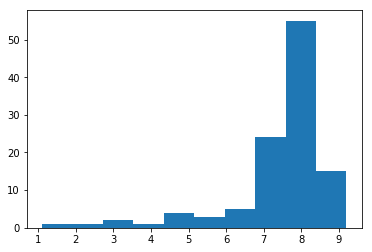

In [127]:
plt.hist(full_df[full_df['Dominant_Topic'] == 1.0]['rest_rating'].values)

### Remove more stopwords and create a new model

In [91]:
#Get new stop words
model_4_stops = get_new_stopwords(lda_model_3, 0)

In [93]:
#Add these stopwords

stpwrds.extend(model_4_stops)

#Preprocess with the new stopwords
dictionary_4, corpus_4, cleaned_tokens_4 = topic_model_preprocess(text=data, STOPWORDS=stpwrds)

# Build the LDA model
lda_model_4 = models.LdaModel(corpus=corpus_4, 
                            num_topics=5, #10 Topics
                            id2word=dictionary_4,
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)

In [94]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_4.log_perplexity(corpus_4))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_4 = CoherenceModel(model=lda_model_4, texts=cleaned_tokens_4, dictionary=dictionary_4, coherence='c_v')
coherence_lda_4 = coherence_model_lda_4.get_coherence()
print('\nCoherence Score: ', coherence_lda_4)


Perplexity:  -8.663765835206299

Coherence Score:  0.3566251288549608


In [96]:
vis_4 = pyLDAvis.gensim.prepare(lda_model_4, corpus_4, dictionary_4)
vis_4

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.280193  0.025763       1        1  63.952709
2      0.109308 -0.042534       2        1  17.775301
0     -0.127398  0.170741       3        1   6.431288
4     -0.125962 -0.174780       4        1   6.281989
3     -0.136141  0.020809       5        1   5.558719, topic_info=      Category        Freq       Term       Total  loglift  logprob
term                                                               
114    Default  171.000000      pizza  171.000000  30.0000  30.0000
275    Default  131.000000      sushi  131.000000  29.0000  29.0000
3223   Default  119.000000    lobster  119.000000  28.0000  28.0000
862    Default   97.000000      ramen   97.000000  27.0000  27.0000
138    Default   90.000000      slice   90.000000  26.0000  26.0000
999    Default  151.000000       pork  151.000000  25.0000  25.0000
2318   Default  137.000000    mexican  137.000000  24.0000  24.0000
602    Default   98.000000      tacos   98.000000  23.0000  23.0000
911    Default   73.000000       blue   73.000000  22.0000  22.0000
3158   Default  102.000000       roll  102.000000  21.0000  21.0000
1073   Default   63.000000      greek   63.000000  20.0000  20.0000
90     Default  101.000000       meat  101.000000  19.0000  19.0000
2117   Default   60.000000        bbq   60.000000  18.0000  18.0000
6826   Default   56.000000  artichoke   56.000000  17.0000  17.0000
112    Default   51.000000        pie   51.000000  16.0000  16.0000
1708   Default   78.000000       beer   78.000000  15.0000  15.0000
502    Default  119.000000      fried  119.000000  14.0000  14.0000
597    Default  109.000000      steak  109.000000  13.0000  13.0000
130    Default   77.000000      sauce   77.000000  12.0000  12.0000
576    Default  118.000000   sandwich  118.000000  11.0000  11.0000
994    Default   39.000000     paella   39.000000  10.0000  10.0000
580    Default  109.000000     served  109.000000   9.0000   9.0000
104    Default   41.000000       oven   41.000000   8.0000   8.0000
2335   Default   42.000000       taco   42.000000   7.0000   7.0000
3669   Default   35.000000       pies   35.000000   6.0000   6.0000
3605   Default   43.000000       clam   43.000000   5.0000   5.0000
8499   Default   36.000000        blt   36.000000   4.0000   4.0000
704    Default  141.000000       line  141.000000   3.0000   3.0000
2727   Default   44.000000   communal   44.000000   2.0000   2.0000
4952   Default   34.000000      kesté   34.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
4696    Topic5    8.917108     empire    9.683321   2.8074  -6.5475
10493   Topic5    8.926315        shy    9.711803   2.8055  -6.5465
5148    Topic5    7.982731        uws    8.702095   2.8035  -6.6582
9842    Topic5    8.546347   critical    9.316867   2.8035  -6.5900
8497    Topic5    8.258778     absurd    9.048321   2.7985  -6.6242
14560   Topic5    7.564705   landmarc    8.288452   2.7984  -6.7120
3584    Topic5    7.745198       ride    8.486854   2.7984  -6.6884
2497    Topic5    9.115185     extent    9.999086   2.7973  -6.5255
3910    Topic5    7.480422  separates    8.216467   2.7960  -6.7232
13982   Topic5    7.544820  barbounia    8.291481   2.7954  -6.7146
8613    Topic5    7.205423       cent    7.926126   2.7945  -6.7606
1150    Topic5    7.381941      dress    8.128976   2.7934  -6.7364
7796    Topic5    7.398071     finger    8.163021   2.7914  -6.7342
911     Topic5   60.854927       blue   73.541512   2.7004  -4.6270
5813    Topic5   12.326088    chopped   14.876361   2.7017  -6.2237
3223    Topic5   63.868622    lobster  119.211136   2.2657  -4.5786
3347    Topic5   15.419898      sized   22.611776   2.5070  -5.9998
7068    Topic5   13.182165  brasserie   18.186920   2.5680  -6.1566
4395    Topic5   15.796355      decor   24.217278   2.4625  -5.9757
7803    Topic5   16.470251  standards   27.

In [109]:
df_topic_sents_keywords_4 = format_topics_sentences(model=lda_model_4, corpus=corpus_4, texts=data)

# Format
df_dominant_topic_4 = df_topic_sents_keywords_4.reset_index()
df_dominant_topic_4.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_4.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3883,"meal, want, find, two, york, thing, every, fir...",A typical NYC slice shop has a few basic eleme...
1,1,1.0,0.5771,"meal, want, find, two, york, thing, every, fir...",Tolerance for group trips can vary widely. Som...
2,2,2.0,0.5018,"mexican, something, sandwich, nyc, pork, dishe...",When the apocalypse eventually comes for New Y...
3,3,2.0,0.5802,"mexican, something, sandwich, nyc, pork, dishe...","When you’re young, you don’t have to think muc..."
4,4,0.0,0.3703,"pizza, sushi, slice, artichoke, pie, pies, kes...","There’s a bleak, sweaty place on 34th Street w..."
5,5,1.0,0.4643,"meal, want, find, two, york, thing, every, fir...",New York is near an ocean with plenty of free ...
6,6,1.0,0.3672,"meal, want, find, two, york, thing, every, fir...","When some things change, they become unrecogni..."
7,7,1.0,0.5457,"meal, want, find, two, york, thing, every, fir...","Around the time Kyma opened, we heard that Bil..."
8,8,1.0,0.9448,"meal, want, find, two, york, thing, every, fir...",We have mixed feelings toward secret places. O...
9,9,2.0,0.8855,"mexican, something, sandwich, nyc, pork, dishe...",Casual weeknight dinners are rarely memorable....


In [110]:
df_dominant_topic_4['Dominant_Topic'].value_counts()

1.0    755
2.0     58
0.0      7
4.0      3
3.0      1
Name: Dominant_Topic, dtype: int64

In [111]:
df_dominant_topic_4['Keywords'].value_counts()

meal, want, find, two, york, thing, every, first, right, actually                   755
mexican, something, sandwich, nyc, pork, dishes, order, find, spanish, porchetta     58
pizza, sushi, slice, artichoke, pie, pies, kesté, oven, joe, strike                   7
ramen, greek, pork, bbq, tacos, paella, mexican, meat, authentic, blt                 3
lobster, blue, ribbon, beer, roll, boat, seafood, mermaid, fried, clam                1
Name: Keywords, dtype: int64